## Word2Vec with CNN
Each word will tranform by pretrained model to vector in size 300 so each instance is atually a matrix

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tfa

In [7]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

In [8]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [9]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [10]:
import gensim.downloader
#glove-twitter-200
glove_vectors = gensim.downloader.load('glove-twitter-50')

In [11]:
import swifter
import re
import nltk
import string

MAX_NUMBER_OF_WORDS = 50
ENCODE_SIZE = 50
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

def get_vector(word):
    try:
        return glove_vectors.get_vector(word)
    except Exception as e:
#         print(e)
        pass
    return np.zeros((ENCODE_SIZE,))

def precoess_row(text):
    text = remove_punct(re.sub(r'\d+', 'number', text))
    vec = np.array([get_vector(word.lower()) for word in nltk.word_tokenize(text)])
    if vec.shape[0] == 0:
        return np.nan
    if vec.shape[0] >= MAX_NUMBER_OF_WORDS:
        vec = vec[:MAX_NUMBER_OF_WORDS,:]
    else:
        vec = np.vstack((vec,np.zeros((MAX_NUMBER_OF_WORDS-vec.shape[0],ENCODE_SIZE))))
    return vec

In [12]:
df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].swifter.apply(precoess_row)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
lst = []
ignored = []
for i,a in enumerate(df[TEXT_COLUMN_NAME]):
    try:
        if a.shape == (50,50):
            lst.append(a)
    except:
        ignored.append(i)
df = df.drop(ignored)

,Text,oh_label
0,"[[0.12588000297546387, 0.7006199955940247, 0.1...",1.0
1,"[[0.7857599854469299, 0.4212400019168854, 0.52...",0.0
2,"[[1.1221, 0.28682, -0.29652, -0.044516, -0.406...",1.0
3,"[[-0.04314799979329109, 0.5039299726486206, 0....",0.0
4,"[[0.9228399991989136, 0.20556999742984772, 0.4...",1.0
...,...,...
99995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
99996,"[[0.6702499985694885, 0.701479971408844, -0.11...",0.0
99997,"[[-0.17872999608516693, -0.5389800071716309, -...",0.0
99998,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0


In [22]:
X = np.stack(lst)
y = df[LABEL_COLUMN_NAME]

In [23]:
X.shape,y.shape

((99988, 50, 50), (99988,))

In [29]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=42)

{0: 0.26774212905548667, 1: 0.7322578709445133}


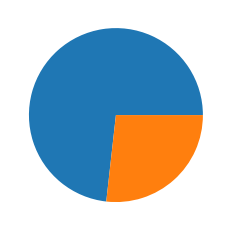

In [31]:
plt.pie(y.value_counts())
x_neg_weight = y[y==1].shape
x_pos_weight = y[y==0].shape
x_neg_weight[0]/x_pos_weight[0]
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}
print(weights)

In [57]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,MaxPool1D,Flatten,Conv2D,Dropout,MaxPooling2D
model = Sequential()
model.add(Conv2D(5,(3,3), use_bias=True,padding="valid",input_shape=(50,50,1)))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.2))
model.add(Conv2D(10,(3,3), use_bias=True,padding="valid"))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 5)         50        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 5)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 5)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 10)        460       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 10)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1210)            

In [40]:
np.expand_dims(x_train,axis=-1).shape,y_train.shape

((74991, 50, 50, 1), (74991,))

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(np.expand_dims(x_train,axis=-1),y_train,batch_size=200,epochs=2000,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/2000
357/357 [==============================] - 20s 54ms/step - loss: 0.2106 - accuracy: 0.7178 - recall_8: 0.7361 - precision_8: 0.4829 - val_loss: 0.4781 - val_accuracy: 0.7725 - val_recall_8: 0.8219 - val_precision_8: 0.5418
Epoch 2/2000
357/357 [==============================] - 19s 52ms/step - loss: 0.1843 - accuracy: 0.7754 - recall_8: 0.7736 - precision_8: 0.5587 - val_loss: 0.4807 - val_accuracy: 0.7675 - val_recall_8: 0.8547 - val_precision_8: 0.5335
Epoch 3/2000
357/357 [==============================] - 18s 51ms/step - loss: 0.1768 - accuracy: 0.7889 - recall_8: 0.7901 - precision_8: 0.5780 - val_loss: 0.5084 - val_accuracy: 0.7384 - val_recall_8: 0.8915 - val_precision_8: 0.4989
Epoch 4/2000
357/357 [==============================] - 18s 51ms/step - loss: 0.1721 - accuracy: 0.7905 - recall_8: 0.7967 - precision_8: 0.5797 - val_loss: 0.4904 - val_accuracy: 0.7528 - val_recall_8: 0.8792 - val_precision_8: 0.5150
Epoch 5/2000
357/357 [==============================] - 

Epoch 36/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.1024 - accuracy: 0.8809 - recall_8: 0.9021 - precision_8: 0.7228 - val_loss: 0.3565 - val_accuracy: 0.8533 - val_recall_8: 0.8178 - val_precision_8: 0.6823
Epoch 37/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.1021 - accuracy: 0.8805 - recall_8: 0.9022 - precision_8: 0.7219 - val_loss: 0.3429 - val_accuracy: 0.8560 - val_recall_8: 0.7871 - val_precision_8: 0.6985
Epoch 38/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.1009 - accuracy: 0.8828 - recall_8: 0.9011 - precision_8: 0.7271 - val_loss: 0.3523 - val_accuracy: 0.8581 - val_recall_8: 0.7973 - val_precision_8: 0.6999
Epoch 39/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.1006 - accuracy: 0.8843 - recall_8: 0.9034 - precision_8: 0.7296 - val_loss: 0.3635 - val_accuracy: 0.8445 - val_recall_8: 0.8362 - val_precision_8: 0.6589
Epoch 40/2000
357/357 [=============================

357/357 [==============================] - 19s 53ms/step - loss: 0.0755 - accuracy: 0.9176 - recall_8: 0.9305 - precision_8: 0.7967 - val_loss: 0.3838 - val_accuracy: 0.8515 - val_recall_8: 0.8127 - val_precision_8: 0.6798
Epoch 105/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0763 - accuracy: 0.9158 - recall_8: 0.9273 - precision_8: 0.7935 - val_loss: 0.3861 - val_accuracy: 0.8499 - val_recall_8: 0.8188 - val_precision_8: 0.6745
Epoch 106/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0745 - accuracy: 0.9172 - recall_8: 0.9303 - precision_8: 0.7956 - val_loss: 0.3912 - val_accuracy: 0.8539 - val_recall_8: 0.8188 - val_precision_8: 0.6832
Epoch 107/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0747 - accuracy: 0.9185 - recall_8: 0.9321 - precision_8: 0.7982 - val_loss: 0.3869 - val_accuracy: 0.8515 - val_recall_8: 0.8178 - val_precision_8: 0.6783
Epoch 108/2000
357/357 [==============================] - 19s 5

357/357 [==============================] - 19s 53ms/step - loss: 0.0664 - accuracy: 0.9288 - recall_8: 0.9395 - precision_8: 0.8211 - val_loss: 0.3922 - val_accuracy: 0.8645 - val_recall_8: 0.7994 - val_precision_8: 0.7145
Epoch 173/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0649 - accuracy: 0.9303 - recall_8: 0.9378 - precision_8: 0.8258 - val_loss: 0.3908 - val_accuracy: 0.8685 - val_recall_8: 0.7932 - val_precision_8: 0.7270
Epoch 174/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0659 - accuracy: 0.9291 - recall_8: 0.9383 - precision_8: 0.8225 - val_loss: 0.3937 - val_accuracy: 0.8723 - val_recall_8: 0.7984 - val_precision_8: 0.7345
Epoch 175/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0656 - accuracy: 0.9292 - recall_8: 0.9399 - precision_8: 0.8218 - val_loss: 0.3868 - val_accuracy: 0.8696 - val_recall_8: 0.8096 - val_precision_8: 0.7230
Epoch 176/2000
357/357 [==============================] - 19s 5

357/357 [==============================] - 19s 53ms/step - loss: 0.0622 - accuracy: 0.9335 - recall_8: 0.9433 - precision_8: 0.8314 - val_loss: 0.3941 - val_accuracy: 0.8749 - val_recall_8: 0.8127 - val_precision_8: 0.7352
Epoch 241/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0614 - accuracy: 0.9345 - recall_8: 0.9424 - precision_8: 0.8348 - val_loss: 0.4023 - val_accuracy: 0.8715 - val_recall_8: 0.7943 - val_precision_8: 0.7342
Epoch 242/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0617 - accuracy: 0.9342 - recall_8: 0.9416 - precision_8: 0.8345 - val_loss: 0.3918 - val_accuracy: 0.8747 - val_recall_8: 0.7922 - val_precision_8: 0.7435
Epoch 243/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0606 - accuracy: 0.9356 - recall_8: 0.9427 - precision_8: 0.8376 - val_loss: 0.3979 - val_accuracy: 0.8728 - val_recall_8: 0.8045 - val_precision_8: 0.7332
Epoch 244/2000
357/357 [==============================] - 19s 5

357/357 [==============================] - 19s 53ms/step - loss: 0.0583 - accuracy: 0.9375 - recall_8: 0.9467 - precision_8: 0.8403 - val_loss: 0.4101 - val_accuracy: 0.8667 - val_recall_8: 0.8066 - val_precision_8: 0.7170
Epoch 309/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0558 - accuracy: 0.9405 - recall_8: 0.9499 - precision_8: 0.8469 - val_loss: 0.4064 - val_accuracy: 0.8744 - val_recall_8: 0.7892 - val_precision_8: 0.7442
Epoch 310/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0570 - accuracy: 0.9399 - recall_8: 0.9476 - precision_8: 0.8466 - val_loss: 0.4124 - val_accuracy: 0.8717 - val_recall_8: 0.7953 - val_precision_8: 0.7344
Epoch 311/2000
357/357 [==============================] - 19s 53ms/step - loss: 0.0578 - accuracy: 0.9381 - recall_8: 0.9450 - precision_8: 0.8433 - val_loss: 0.4065 - val_accuracy: 0.8720 - val_recall_8: 0.7963 - val_precision_8: 0.7347
Epoch 312/2000
357/357 [==============================] - 19s 5

In [59]:
model.save("cnn_glove2")

INFO:tensorflow:Assets written to: cnn_glove2\assets


In [60]:
from sklearn.metrics import classification_report
pred = model.predict(np.expand_dims(x_test,axis=-1)).flatten()
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     18315
         1.0       0.73      0.82      0.77      6682

    accuracy                           0.87     24997
   macro avg       0.83      0.85      0.84     24997
weighted avg       0.88      0.87      0.87     24997

